In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sci
import scipy.special as scisp
import scipy.stats as scist
import datetime, copy, imp
import re
import sys
import random

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix 
import MySQLdb

import pymysql.cursors;

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

tqdm.pandas()
plt.ion()

## Ng Data
- This data is provided as part of Andrew Ng's Coursera machine learning course and can be downloaded [here](https://github.com/animesh-agarwal/Machine-Learning/blob/master/LogisticRegression/data/marks.txt).

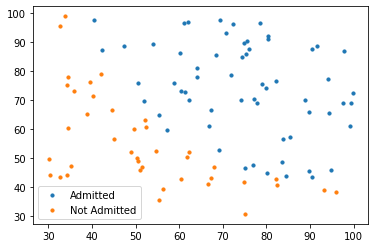

In [2]:
data = pd.read_csv('~/data/tutorial/ng-marks.txt',header=None)
    
xNg = data.iloc[:, :-1]
yNg = data.iloc[:, -1]
p = 2

admitted = data.loc[yNg == 1]
not_admitted = data.loc[yNg == 0]

plt.scatter(admitted.iloc[:, 0], admitted.iloc[:, 1], s=10, label='Admitted')
plt.scatter(not_admitted.iloc[:, 0], not_admitted.iloc[:, 1], s=10, label='Not Admitted')
plt.legend()
plt.show()

In [3]:
# The confusion matrix is typically for the first row to be positive so we switch
# the positive case (admitted) to correspond to class 0.
y = np.zeros(len(yNg))
y[ yNg.to_numpy() == 0 ] = 1
x = xNg.to_numpy()

nrm = np.ones((1,p))
nrm = np.sqrt(x.var(axis=0))
x = x/nrm

In [4]:
classes = yNg.unique()
for iClass in classes:
    print('Number in class %d: %d' % (iClass,sum(y==iClass)))

Number in class 0: 60
Number in class 1: 40


The positive case is Class 1 (admitted).  We have more positive cases but the data is still approximately balanced.

The logistic regression routine also supports various regularization parameters.  The "l1" regularlization applies a penalty to the magnitude of the model coefficients and is analagous to lasso.  This is a good choice when attempting to find a sparse model.

In [5]:
cs = [ 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5 ]


betas = np.zeros((p,len(cs)))

j = 0
for c in cs:
    lgModel = LogisticRegression(C=c,penalty='l1',solver='liblinear',max_iter=1000)
    lgModel.fit(x,y)
    betas[:,j] = lgModel.coef_
    j += 1

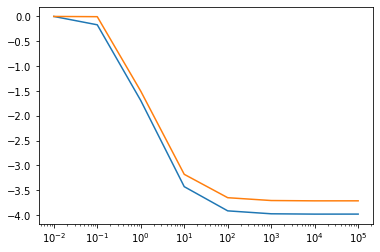

In [6]:
fig = plt.semilogx(cs,betas.T)

The coefficients are basically in proportion except for $C$=0.1 where it appears we could remove one of the features from the dataset.

## Evaluating Classification Performance

- For the following, assume a $K=2$ binary classifier.
- The training set contains some set of positive cases, $P$, and negative cases, $N$ so that the total number of training examples in our set is $M = |P| + |M|$.
- The classifier is attempting to identify the positive cases and its operation is denoted by the $\hat{\cdot}$ symbol.
- After applying the classifier to the training set, we have the following four sets:
  1. True positives, $\hat{P}$.
  1. False positives, $\hat{N}$.
  1. True negatives, $\bar{N} = N - \hat{N}$.
  1. False negatives, $\bar{P} = P - \hat{P}$.
- It helps to think of the hat indicating elements the test thinks are positive and the bar indicating elements that the test thinks are negative.

### Confusion Matrix
- If we have $K$ classes, the confusion matrix is $K \times K$.  The row and column indices correspond to the class indicies and element $ij$ is the number of times a datapoint from class $i$ is identified by the algorithm as class $j$.  A perfect predictor has a diagonal confusion matrix.
- If $K=2$, the confusion matrix elements are:

$$
\left[
\begin{array}{cc}
|\hat{P}| & |\hat{N}| \\
|\bar{P}| & |\bar{N}|
\end{array}
\right]
$$


### Metrics

- **Confidence/Precision:**
  - $|\hat{P}|/(|\hat{P}+\hat{N}|) \simeq P(\mbox{positive sample}|\mbox{positive classification})$
  - A conservative test with a large number of false negatives could have very high confidence.
  
- **Recall/Sensitivity/True Positive Rate:**
  - $|\hat{P}|/|P| \simeq P(\mbox{positive classification}|\mbox{positive sample})$
  - Evaluates how good we are at spotting positive cases.
  - A sloppy test that indicates a positive result for all samples would have a sensitivity of 1.
  
- **False Positive Rate:**
  - $|\hat{N}|/|N| \simeq P(\mbox{positive classification}|\mbox{negative sample})$
  - Indicates the proportion of negative samples that are classified as positive.
  - Similar to accuracy, this metric rewards conservative tests with a high number of false negatives since we're looking for a value of 0 here (false positives are bad).

- **Specificity/True Negative Rate:**
  - $|\bar{N}|/|N| = (|N|-|\hat{N}|)/|N| \simeq P(\mbox{negative classification}|\mbox{negative sample})$
  - Actually the same as false positive rate since we want a value of 1 here (true negatives are good) so we reward a conservative test with no false positives.
  
- **Accuracy:**
  - $(|\hat{P}|+|\bar{N}|)/(|N|+|P|) \simeq P(\mbox{correct classification})$
  - Rewards *both* good coverage/sensitivity (large $\hat{P}$) and good confidence/specificity (small $\hat{N}$ or large $\bar{N}$).
  - Actually equivalent to the rate difference metric $|\hat{P}|/|P| - |\hat{N}|/|N|$ so that the contribution of true positives and false negatives are weighted proportional to the number of positive and negative samples, respectively.
  - In the case with a small number of positives (rare diseases), this favours sensitivity at the expense of some false positives.

In [7]:
tPos = (0,0)
fPos = (0,1)
fNeg = (1,0)
tNeg = (1,1)

def CalcConfidence(cnf):
    return cnf[tPos]/(cnf[tPos]+cnf[fPos])

def CalcAccuracy(cnf):
    nPos = cnf[tPos] + cnf[fNeg]
    nNeg = cnf[fPos] + cnf[tNeg]
    return (cnf[tPos] + (nNeg-cnf[fPos]))/(nNeg+nPos)

def CalcSpecificity(cnf):
    nNeg = cnf[fPos] + cnf[tNeg]
    return (nNeg-cnf[fPos])/nNeg

def CalcSensitivity(cnf):
    nPos = cnf[tPos] + cnf[fNeg]
    return cnf[tPos]/nPos


The following routine calculates an average confusion matrix using a randomized, non-exhaustive holdout cross validation approach.  The specific classifcation algorithm function is passed as an argument (in this case its sci-kit learn logistic regression with a specific $C$ value).

In [8]:
def LgRegression(xT,yT,x):
    lgModel = LogisticRegression(C=1e3)
    lgModel.fit(xT,yT)
    return lgModel.predict(x)


def HoldoutCvConfusion(cvFrac,nIter,x,y,classFunc):
    
    m = len(y)
    p = len(x[0,:])-1
    k = len(np.unique(y))

    mTrain = int(m*(1-cvFrac))
    xTrain = np.zeros((mTrain,p+1))
    xCv = np.zeros((m-mTrain,p+1))
    yTrain = np.zeros(mTrain)
    yCv = np.zeros(m-mTrain)

    avgCnfMtx = np.zeros((k,k))
    

    for iter in range(0,nIter):
    
        indTrain = random.sample(range(m),mTrain)
        indCv = [ i for i in range(m) if i not in indTrain ]
    
        xTrain[:,:] = x[indTrain,:]
        yTrain[:] = y[indTrain]
        xCv[:,:] = x[indCv,:]
        yCv[:] = y[indCv]

        yClass = classFunc(xTrain,yTrain,xCv)
        
        cnfMtx = confusion_matrix(yCv,yClass)
        
        avgCnfMtx += cnfMtx
    
    return avgCnfMtx / nIter    
    
avgCnfMtx = HoldoutCvConfusion(cvFrac = 0.3, nIter = 4, x=x, y=y, classFunc=LgRegression)

# Note that the cell counts in this confusion matrix correspond to 30% of the total data size because
# that's how much data is held back from training and used to evaluate generalization error.
avgCnfMtx

array([[15.25,  2.5 ],
       [ 1.25, 11.  ]])

In [9]:
print('Confidence: %g' % (CalcConfidence(avgCnfMtx)))
print('Accuracy: %g' % (CalcAccuracy(avgCnfMtx)))
print('Specificity: %g' % (CalcSpecificity(avgCnfMtx)))
print('Sensitivity: %g' % (CalcSensitivity(avgCnfMtx)))

Confidence: 0.859155
Accuracy: 0.875
Specificity: 0.814815
Sensitivity: 0.924242


## Model Selection
Examine what value of regularization parameter $C$ yields the best classification performance.

In [10]:
def LgRegressionWithC(xT,yT,x):
    lgModel = LogisticRegression(C=curC,penalty='l1',solver='liblinear',max_iter=10000)
    lgModel.fit(xT,yT)
    return lgModel.predict(x)

cs = [ 1e0, 1e1, 1e2, 1e3, 1e4, 1e5 ]


betas = np.zeros((p,len(cs)))

conf = np.zeros(len(cs))
acc = np.zeros(len(cs))
spec = np.zeros(len(cs))
sens = np.zeros(len(cs))
cnfMtxs = np.zeros((len(cs),2,2))

j = 0
for curC in cs:
    lgModel = LogisticRegression(C=curC,penalty='l1',solver='liblinear',max_iter=1000)
    lgModel.fit(x,y)
    betas[:,j] = lgModel.coef_
    
    avgCnfMtx = HoldoutCvConfusion(cvFrac = 0.25, nIter = 500, x=x, y=y, classFunc=LgRegressionWithC)
    
    conf[j] = CalcConfidence(avgCnfMtx)
    acc[j] = CalcAccuracy(avgCnfMtx)
    spec[j] = CalcSpecificity(avgCnfMtx)
    sens[j] = CalcSensitivity(avgCnfMtx)
    cnfMtxs[j,:,:] = avgCnfMtx
    
    j += 1

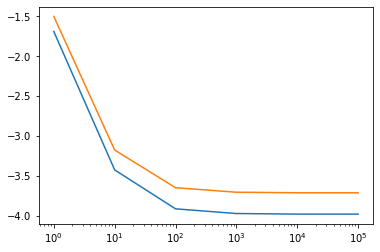

In [11]:
fig = plt.semilogx(cs,betas.T)

In this case, the parameters are affected approximately equally by regularization so there's no opportunity to eliminate an input data feature.

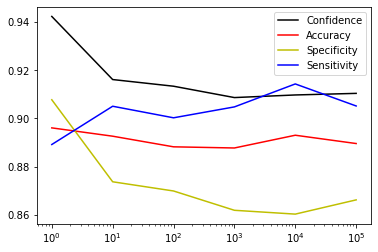

In [12]:
fig = plt.figure()
plt.semilogx(cs,conf,label='Confidence',color='k')
plt.semilogx(cs,acc,label='Accuracy',color='r')
plt.semilogx(cs,spec,label='Specificity',color='y')
plt.semilogx(cs,sens,label='Sensitivity',color='b')

plt.legend()
plt.show()

In [13]:
# Confusion matrix for the final value of C
cnfMtxs[5,:,:]

array([[13.576,  1.338],
       [ 1.424,  8.662]])

- High confidence means that the number of false positives relative to true positives is fairly small.
- High sensitivity means we're getting good coverage of the positive data points.  The number of false negatives is small compared to the number of positive data points.
- Specificity is a bit lower than confidence.  This means that the number of false positives is more significant when compared to the number of negative data points.
- Accuracy is reasonable which means we do a good job of balancing true positives and true negatives.

## Load & Classify Players
We now consider a baseball player scenario where we try to use logistic regression to identify a small number of positive data points among a much larger number of negative data points.  This would be similar to designing a test taken by many people to detect a rare disease.

In [14]:
players = pd.read_hdf('~/data/baseball/PlayerSummary-2018.hdf',key='Data')
players = players[players.Position != 'Pitcher']
nPlayers = len(players.index)
players

,Position,GamesPlayed,AtBats,AvgOuts,AvgOnBase,AvgRuns,AvgRbis
PlayerId,,,,,,,
abrej003,FirstBase,129,549,7.139535,0.327869,0.123862,0.078324
acunr001,LeftField,111,484,1.657658,0.367769,0.161157,0.070248
adaml001,LeftField,24,28,0.375000,0.357143,0.357143,0.142857
adamm002,FirstBase,117,332,3.658120,0.313253,0.126506,0.108434
adamw002,ShortStop,85,320,2.882353,0.350000,0.134375,0.059375
...,...,...,...,...,...,...,...
zagum002,RightField,5,6,0.400000,0.500000,0.000000,0.000000
zimmb001,CenterField,36,114,2.277778,0.280702,0.122807,0.052632
zimmr001,FirstBase,85,318,6.541176,0.342767,0.103774,0.103774


Place players in two classes based on whether they've played more than a certain number of games.  The positive case (class 0) is assigned to players that have exceeded the games played threshold.

In [15]:
gameThresh = 150
players['Class'] = pd.Series([1]*nPlayers,index = players.index)
players.loc[players.GamesPlayed > gameThresh,'Class'] = 0

classes = players.Class.unique()
for iClass in classes:
    print('Number in class %d: %d (%.1f%%)' 
          % ( iClass, sum(players.Class == iClass), 100.0*sum(players.Class == iClass)/nPlayers))

Number in class 1: 559 (91.0%)
Number in class 0: 55 (9.0%)


## Prep and Normalize Data

### Linear Features

In [16]:
m = len(players.index)
p = 4

# Target variable
y = np.array(players.Class)

# Input variables
x = np.zeros((m,p))
x[:,:] = players[['AvgOuts','AvgOnBase','AvgRuns','AvgRbis']].to_numpy()

In [17]:
nrm = np.sqrt(x.var(axis=0))
x = x/nrm

In [18]:
def LgRegressionWithCPlayers(xT,yT,x):
    lgModel = LogisticRegression(C=curC,penalty='l1',solver='liblinear',max_iter=1000)
    lgModel.fit(xT,yT)
    return lgModel.predict(x)

cs = [ 1e0, 1e1, 1e2, 1e3, 1e4, 1e5 ]


betas = np.zeros((p,len(cs)))

conf = np.zeros(len(cs))
acc = np.zeros(len(cs))
spec = np.zeros(len(cs))
sens = np.zeros(len(cs))
cnfMtxs = np.zeros((len(cs),2,2))

j = 0
for curC in cs:
    lgModel = LogisticRegression(C=curC,penalty='l1',solver='liblinear',max_iter=1000)
    lgModel.fit(x,y)
    betas[:,j] = lgModel.coef_
    
    avgCnfMtx = HoldoutCvConfusion(cvFrac = 0.25, nIter = 75, x=x, y=y, classFunc=LgRegressionWithCPlayers)
    cnfMtxs[j,:,:] = avgCnfMtx
    
    conf[j] = CalcConfidence(avgCnfMtx)
    acc[j] = CalcAccuracy(avgCnfMtx)
    spec[j] = CalcSpecificity(avgCnfMtx)
    sens[j] = CalcSensitivity(avgCnfMtx)
    
    j += 1

In [19]:
cnfMtxs[5,:,:]

array([[  1.12      ,  12.30666667],
       [  1.74666667, 138.82666667]])

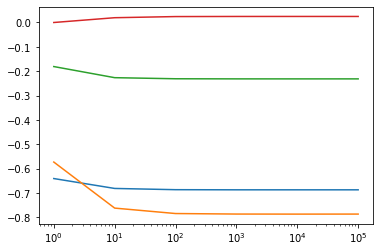

In [20]:
fig = plt.semilogx(cs,betas.T)

According to these results, the contribution of RBIs is low and could likely be removed.  This is consistent with the linear regression results we generated for this same dataset.

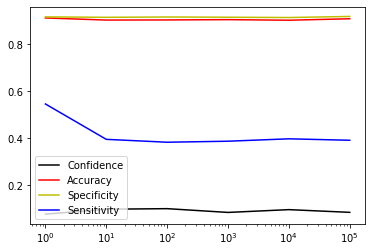

In [21]:
fig = plt.figure()
plt.semilogx(cs,conf,label='Confidence',color='k')
plt.semilogx(cs,acc,label='Accuracy',color='r')
plt.semilogx(cs,spec,label='Specificity',color='y')
plt.semilogx(cs,sens,label='Sensitivity',color='b')

plt.legend()
plt.show()

With this dataset, we can see from the confusion matrix that we have a hard time identifying true positives.  As a result:
- Our confidence is low due to the large number of false positives.
- The large number of false positives also means that our sensitivity is quite low (poor coverage of the positive data set).
- Specificity is high since the number of false positives is small compared to the large number of true negatives.
- Accuracy is also high since the number of true negatives and negative samples in general is large compared to the positive samples.

This reveals that accuracy and specificity are not necessarily the best metrics when attempting to detect a small number of positive data points buried in a large number of negative data points.

### Higher Order Polynomials
Drop the RBI and Runs features and use default solver parameters to help with convergence.

In [22]:
m = len(players.index)
p = 4

# Target variable
y = np.array(players.Class)

# Input variables
x = np.zeros((m,p))
x[:,0:2] = players[['AvgOuts','AvgOnBase']].to_numpy()
x[:,2:] = players[['AvgOuts','AvgOnBase']].to_numpy() **2

In [23]:
nrm = np.sqrt(x.var(axis=0))
x = x/nrm

In [24]:
def LgRegressionWithCPlayers(xT,yT,x):
    lgModel = LogisticRegression(C=curC)
    lgModel.fit(xT,yT)
    return lgModel.predict(x)

cs = [ 1e0, 1e1, 1e2, 1e3,  ]


betas = np.zeros((p,len(cs)))

conf = np.zeros(len(cs))
acc = np.zeros(len(cs))
spec = np.zeros(len(cs))
sens = np.zeros(len(cs))
cnfMtxs = np.zeros((len(cs),2,2))

j = 0
for curC in cs:
    lgModel = LogisticRegression(C=curC)
    lgModel.fit(x,y)
    betas[:,j] = lgModel.coef_
    
    avgCnfMtx = HoldoutCvConfusion(cvFrac = 0.25, nIter = 75, x=x, y=y, classFunc=LgRegressionWithCPlayers)
    cnfMtxs[j,:,:] = avgCnfMtx
    
    conf[j] = CalcConfidence(avgCnfMtx)
    acc[j] = CalcAccuracy(avgCnfMtx)
    spec[j] = CalcSpecificity(avgCnfMtx)
    sens[j] = CalcSensitivity(avgCnfMtx)
    
    j += 1

In [25]:
cnfMtxs[3,:,:]

array([[  0.38666667,  13.32      ],
       [  1.42666667, 138.86666667]])

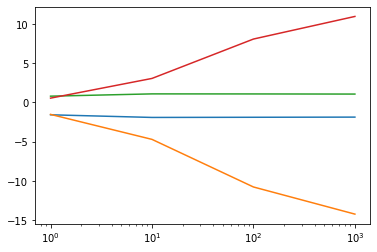

In [26]:
fig = plt.semilogx(cs,betas.T)

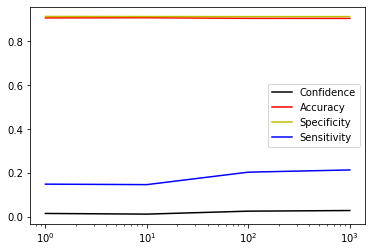

In [27]:
fig = plt.figure()
plt.semilogx(cs,conf,label='Confidence',color='k')
plt.semilogx(cs,acc,label='Accuracy',color='r')
plt.semilogx(cs,spec,label='Specificity',color='y')
plt.semilogx(cs,sens,label='Sensitivity',color='b')

plt.legend()
plt.show()

Performance actually gets a bit worse using these higher order data features.

## Class Masking
- This code reproduces the masking example in Figs. 4.2 and 4.3 of Elements of Statistical Learning.

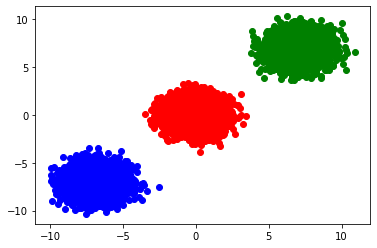

In [28]:
m = 12000
x = np.random.normal(size=(m,2))
c1 = range(0,int(m/3))
c2 = range(int(m/3),int(m*2/3))
c3 = range(int(m*2/3),m)

x[c1,:] += -7
x[c3,:] += 7

plt.plot(x[c1,0],x[c1,1],marker='o',ls='none',color='b')
plt.plot(x[c2,0],x[c2,1],marker='o',ls='none',color='r')
plt.plot(x[c3,0],x[c3,1],marker='o',ls='none',color='g')

The data clouds shown above are similar to Fig. 4.2.

In [29]:
y = np.zeros((m,3))
y[c1,0] = 1
y[c2,1] = 1
y[c3,2] = 1

b = np.linalg.inv( x.T @ x ) @ x.T @ y
b

array([[-0.03632406,  0.00094084,  0.03379325],
       [-0.034218  , -0.00086722,  0.03661677]])

In [30]:
f = x @ b
cHat = f.argmax(axis=1) + 1
cHat1 = np.argwhere(cHat == 1)
cHat2 = np.argwhere(cHat == 2)
cHat3 = np.argwhere(cHat == 3)

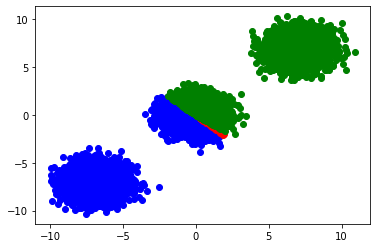

In [31]:
plt.plot(x[cHat1,0],x[cHat1,1],marker='o',ls='none',color='b')
plt.plot(x[cHat2,0],x[cHat2,1],marker='o',ls='none',color='r')
plt.plot(x[cHat3,0],x[cHat3,1],marker='o',ls='none',color='g')

This confirms the result in Fig. 4.2.  Essentially, the decision boundary sets up exactly between classes 1 and 3 with class 2 being cut in half.

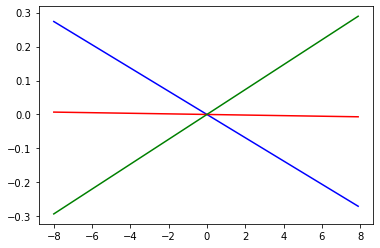

In [32]:
xFix = 0

xRng = np.arange(-8,8,0.1)
c1Line = b[0,0]*xFix + xRng*b[1,0]
c2Line = b[0,1]*xFix + xRng*b[1,1]
c3Line = b[0,2]*xFix + xRng*b[1,2]

plt.plot(xRng,c1Line,color='b')
plt.plot(xRng,c2Line,color='r')
plt.plot(xRng,c3Line,color='g')

This is a replication of Fig. 4.3.  This figure does not show decision boundaries or best fit lines to the data.  Instead, these are the indicator function values when the first x-feature is fixed and the second one is allowed to vary (this isn't explicitly noted in the textbook).  We note that the indicator for class 2 is never higher than for class 1 and 3.  Changing `xFix` just moves the intersection of the class 1 and 2 indicators back and forth. The text makes reference to this being a limitation of the linear decision boundaries and that it can be mitigated by using higher order polynomial data features.

## Unused Code

In [ ]:
# Work in progress.  Gradient descent routing for solving logistic regression coefficients for an
# arbitrary number of classes.  No regularization.  This code is not used to generate any results in this notebook.
def FindBeta(stopThrsh,alpha,y,x,beta):
    
    k = len(beta[0,:])+1
    p = len(beta[:,0])-1
    m = len(y)
    
    llPrev = np.log(m/k)  # The lowest possible log-likelihood value.
    llDiff = 1
    
    iter = 0
    while llDiff > stopThrsh:
        
        grdBeta = np.zeros((p+1,k-1))
    
        for i in range(m):
        
            xi = np.array([x[i,:]]).T
            expVals = np.exp( beta.T @ xi )
            prbYgvXi = expVals/(1+sum(expVals))

            indFn = np.zeros((k-1,1))
            if y[i] < k:
                indFn[y[i,0]-1] = 1
            
            grdBeta += np.tile(xi,(1,k-1)) * (indFn - prbYgvXi).T
        
        beta += alpha * grdBeta
        
        ll = 0
        for i in range(m):
            expVals = np.exp( beta.T @ x[i,:] )
            prbYgvXi = expVals/(1+sum(expVals))
        
            if y[i] == k:
                ll += np.log(1 - sum(prbYgvXi))
            else:
                ll += np.log(prbYgvXi[y[i]-1])
        
        llDiff = (llPrev-ll)/llPrev
        llPrev = ll
        
        print('%d. LogLikelihood: %g, Likelihood: %g, Convergence Difference: %g' % (iter, ll, np.exp(ll),llDiff))
        iter += 1
        
    return beta
    
beta = FindBeta(0.05,0.5,y,x,beta)    
    

## Notes

- This section includes some notes related to Chapter 4 of [Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf).

### Introduction

- Linear classifiers use linear boundaries to divide a data set into groups.
- Regression methods define *discriminant functions* $\delta_k(x)$ for each class where we choose the largest function as corresponding with the data.
- These discriminant functions can also be posterior probabilities $P(G=k|X=x)$.
- Our decision boundaries are linear if the discriminant functions or posterior probabilities, or some monotone transformation of them, are linear in $x$.
- While our boundaries are linear, we can incorporate data taken to exponents of $>1$ and cross products of data features.  Our boundaries remain linear in these higher order terms but we effectively are bending our boundaries when we use a basis transformation of the data.

### Linear Regression of an Indicator Matrix
- Assume we have $K$ classes and $M$ training samples.  Our training data is classified by an indicator function with $y_k = 1$ if $G=k$ else 0.
- The *indicator response matrix* is an $M \times K$ matrix $\mathbb{Y}$ of 0's and 1's.
- We then calculate the linear regression coefficients for the training data, $\mathbb{B}$, which is a $(P+1) \times K$ matrix
- For new data, we calculate the vector of $K$ regression values and choose the largest one.
- This can be justified by viewing the regression values as estimates of the conditional expectation of the random variable $Y_k$, $E(Y_k|X=x) = P(G=k|X=x)$.
- Masking is an issue (see above).

### Linear Discriminant Analysis (LDA)
- Assume that the indicator function $f_k(x)$ is the class conditional density of $X$ in class $k$, $f_X(x|G=k)$.  We can then use Bayes theorem to find the aposteriori $P(G=k|X=x)$ if we have the apriori probabilities $\pi_k$.
- We can model $f_k(x)$ as a multi-variate Gaussian with mean $\mu_k$ and covariance matrix $\Sigma_k$.
- LDA assumes that all classes have a common covariance.  The log-likelihood ratio of posterioris is a linear equation in $x$.
- The linear indicators are functions of the prioris, means and covariances.  These are estimated from the data in the usual way.
- LDA does not suffer from masking.
- *Quadratic discriminant analysis* (QDA) results when the covariance matricies are different.  It's quadratic since we're multiplying the $x$ vector with the transpose of itself.
- Regularization produces a mix of unique and common convariances.  No complexity improvement but it's more for model/complexity selection.

- QDA computations can be simplified if diagonalize the covariance matrix.
- The centroids of $K$ classes exist in an affine subspace with dimension $\leq K-1$.  We can then project the data vector to the centroid subspace.
- Fisher projection provides some guidance for this.

### Logistic Regression
- Logistic regression is designed to have log-likelihood ratios that are linear in x.  Arbitrarily, all of these log-likelihood ratios are normalized by the probability for case $K$.  
- The most likely class is simply the one with the largest normalized log ratio value.  
- If we assume that all classes are normalized by class $K$, the final log ratio will be class $K$ normalized by itself which yields a value of $\log(1) = 0$.  So, we choose class $K$ if all other linear values are negative.

- Hastie suggests a negative Z-score means the coefficient is less significant.  Wouldn't the absolute value of the Z-score really be what we're looking for here?
- The model may naturally prune correlated variables and choose one over the other (e.g. obesity in the South African example).
- The quadratic approximations section makes reference to weighted least squares and some methods for efficiently calculating coefficients.
- There's a lot of functionality rolled into the R model selection routines.  Need to be careful that what we're doing doesn't over-simplify.
- Lasso and LAR can be used.

- Logisitic regression is generally chosen over LDA since it makes fewer assumptions.  Hastie thinks they perform about the same.

#### Multinomial Distributions
- Wikipedia has a discussion of the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution).
- Understanding the domain of the PMF is important.  The PMF domain has $k$ dimensions (one for each category) where the values taken on in each dimension are the whole numbers ${0,\ldots n}$ where $n$ is the number of trials.  The values of the $k$ dimensions are restricted to sum to $n$ since the PMF tells us the probability that the results of $n$ trials are a certain mix of counts in each category.
- While the Bernoulli and binomial distributions are special cases of the multinomial distribution, their domains are modified.  The Bernouli distribution domain is the class index ${0,1}$ rather than ${1,2}$.  The binomial distribution is $x_2$, where $x_1$ is always zero (using the wikipedia notation).



